In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from BO.Acquisition.acq import UCB, EI, PI, KG, find_next_batch
import numpy as np
import matplotlib.pyplot as plt
import kernel as kernel
from cigp_withMean import CIGP_withMean

## Define the objective function
This objective function represents a simple sum of sine functions. The goal is to demonstrate a basic mathematical function that exhibits periodic behavior with different frequencies. The input 'x' is the variable at which the sine functions are evaluated, and the result is the sum of sin(x) and sin(2x).

In [21]:
def objective_function(x):
    # Simple sum of sine functions for demonstration
    return torch.sin(x)+torch.sin(2*x)

## Initialize prior knowledge with 5 random points

In [22]:
input_dim = 1
num_initial_points = 5
train_x = torch.rand(num_initial_points, input_dim) * 10  # Random points in [0, 10] for each dimension
train_y = objective_function(train_x).reshape(-1,1)

# Initialize the surrogate model
This code initializes a surrogate model for Bayesian optimization. The surrogate model (CIGP_withMean) is equipped with a chosen kernel (ARDKernel) to capture the underlying patterns in the data.  The Adam optimizer is then set up to optimize the model's parameters during the training process. 

In [23]:
kernel1 = kernel.ARDKernel(1)
# kernel1 = kernel.MaternKernel(1)
# kernel1 = kernel.LinearKernel(1,-1.0,1.)
# kernel1 = kernel.SumKernel(kernel.LinearKernel(1), kernel.MaternKernel(1))
model = CIGP_withMean(1, 1, kernel=kernel1, noise_variance=2.)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Define the mean and variance functions for acq function
The defined mean and variance functions extract the predictive mean and variance from the trained surrogate model (model) when provided with input points (X). These functions are crucial components in the computation of acquisition functions, such as the Upper Confidence Bound (UCB), and are used to guide the selection of the next point for evaluation in the Bayesian optimization process.

In [24]:
def mean_function(X):
    model.eval()
    with torch.no_grad():
        mean, _ = model.forward(train_x, train_y, X)
        return mean

def variance_function(X):
    model.eval()
    with torch.no_grad():
        _, var = model.forward(train_x, train_y, X)
        return var

# Initialize acq function
The code snippet initializes different acquisition functions for Bayesian optimization.

In [25]:
ucb = UCB(mean_function, variance_function, kappa=5)
pi = PI(mean_function, variance_function)
ei = EI(mean_function, variance_function)
kg = KG(mean_function, variance_function, num_fantasies=10)
best_y = []
# use it to remember the key iteration
key_iterations = [2,4,5,6,8,10]
predictions = []
iteration_label = True


# Bayesian optimization loop6
The key iterations allow monitoring the model's behavior and predictions at specific points during the optimization process. The overall process aims to iteratively improve the surrogate model and select points for evaluation that are expected to yield the best objective values.

In [26]:
bounds = np.array([[0, 10]] * input_dim)
for iteration in range(10):  # Run for 5 iterations

    for i in range(100):
        optimizer.zero_grad()
        loss = -model.log_likelihood(train_x, train_y)
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

    batch_points = find_next_batch(ucb, bounds, batch_size=1, n_samples=500, f_best=train_x[np.argmax(train_y)])
    batch_points = torch.tensor(batch_points).float()

    # Evaluate the objective function
    new_y = objective_function(batch_points.squeeze()).reshape(-1,1)

    # Update the model
    train_x = torch.cat([train_x, batch_points])
    train_y = torch.cat([train_y, new_y])
    # Store the best objective value found so far
    best_y.append(new_y.max().item())
    # Visualization

    # Save model predictions during critical iterations
    if (iteration + 1) in key_iterations:
        model.eval()
        fixed_dims = torch.full((1, input_dim - 1), 5.0)  # Example: set them to the midpoint (5.0)
        test_points = torch.linspace(0, 10, 100)
        test_X = torch.cat((test_points.unsqueeze(1), fixed_dims.expand(test_points.size(0), -1)), 1)
        true_y = objective_function(test_X)

        with torch.no_grad():
            pred_mean, pred_std = model.forward(train_x, train_y, test_X)
            predictions.append((pred_mean, pred_std))


iter 0 nll:7.05117
iter 1 nll:7.04339
iter 2 nll:7.03562
iter 3 nll:7.02784
iter 4 nll:7.02007
iter 5 nll:7.01230
iter 6 nll:7.00453
iter 7 nll:6.99677
iter 8 nll:6.98901
iter 9 nll:6.98125
iter 10 nll:6.97350
iter 11 nll:6.96576
iter 12 nll:6.95803
iter 13 nll:6.95031
iter 14 nll:6.94261
iter 15 nll:6.93491
iter 16 nll:6.92723
iter 17 nll:6.91957
iter 18 nll:6.91192
iter 19 nll:6.90430
iter 20 nll:6.89669
iter 21 nll:6.88910
iter 22 nll:6.88154
iter 23 nll:6.87400
iter 24 nll:6.86649
iter 25 nll:6.85901
iter 26 nll:6.85155
iter 27 nll:6.84413
iter 28 nll:6.83674
iter 29 nll:6.82938
iter 30 nll:6.82206
iter 31 nll:6.81478
iter 32 nll:6.80753
iter 33 nll:6.80033
iter 34 nll:6.79316
iter 35 nll:6.78604
iter 36 nll:6.77896
iter 37 nll:6.77192
iter 38 nll:6.76493
iter 39 nll:6.75799
iter 40 nll:6.75110
iter 41 nll:6.74425
iter 42 nll:6.73745
iter 43 nll:6.73070
iter 44 nll:6.72399
iter 45 nll:6.71734
iter 46 nll:6.71073
iter 47 nll:6.70417
iter 48 nll:6.69766
iter 49 nll:6.69120
iter 50 nl

C:\Users\24779\AppData\Local\Temp\ipykernel_7752\926669047.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_points = torch.tensor(batch_points).float()


iter 73 nll:7.78054
iter 74 nll:7.78096
iter 75 nll:7.78029
iter 76 nll:7.78110
iter 77 nll:7.78153
iter 78 nll:7.78088
iter 79 nll:7.78048
iter 80 nll:7.78090
iter 81 nll:7.78024
iter 82 nll:7.78113
iter 83 nll:7.78156
iter 84 nll:7.78092
iter 85 nll:7.78043
iter 86 nll:7.78084
iter 87 nll:7.78019
iter 88 nll:7.78116
iter 89 nll:7.78159
iter 90 nll:7.78096
iter 91 nll:7.78037
iter 92 nll:7.78077
iter 93 nll:7.78013
iter 94 nll:7.78120
iter 95 nll:7.78163
iter 96 nll:7.78100
iter 97 nll:7.78030
iter 98 nll:7.78070
iter 99 nll:7.78006
Number of parameters in forward function: 1
iter 0 nll:9.12818
iter 1 nll:9.12839
iter 2 nll:9.12706
iter 3 nll:9.12837
iter 4 nll:9.12920
iter 5 nll:9.12845
iter 6 nll:9.12632
iter 7 nll:9.12922
iter 8 nll:9.13066
iter 9 nll:9.13053
iter 10 nll:9.12902
iter 11 nll:9.12625
iter 12 nll:9.12931
iter 13 nll:9.13133
iter 14 nll:9.13177
iter 15 nll:9.13083
iter 16 nll:9.12864
iter 17 nll:9.12632
iter 18 nll:9.12795
iter 19 nll:9.12807
iter 20 nll:9.12685
iter 2

# plot the picture
This visualization helps to understand how well the Gaussian Process model captures the true function and how uncertainty evolves as more samples are acquired during the optimization process.

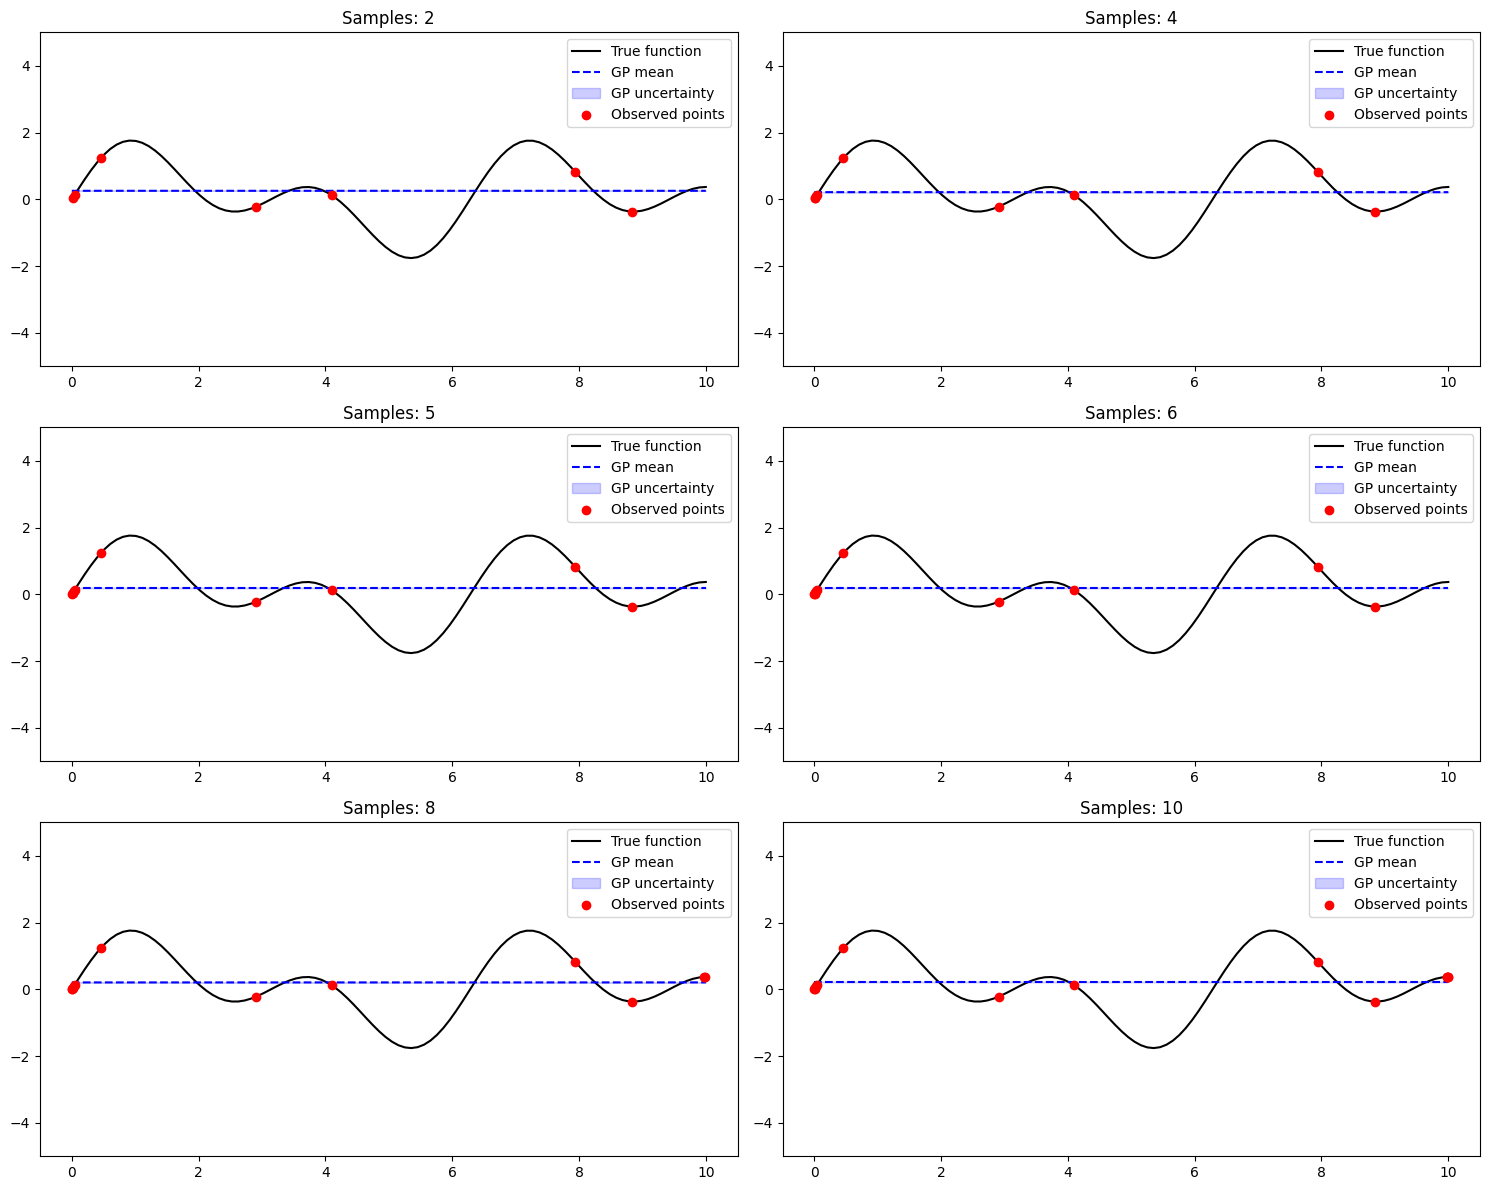

In [27]:
plt.figure(figsize=(15, 12))
for i, (pred_mean, pred_std) in enumerate(predictions):
    plt.subplot(3, 2, i+1)
    plt.ylim(-5, 5)
    plt.plot(test_points.numpy(), true_y.numpy(), 'k-', label='True function')
    plt.plot(test_points.numpy(), pred_mean.numpy(), 'b--', label='GP mean')
    plt.fill_between(test_points.numpy().reshape(-1),
                     (pred_mean - 2 * pred_std).numpy().reshape(-1),
                     (pred_mean + 2 * pred_std).numpy().reshape(-1),
                     color='blue', alpha=0.2, label='GP uncertainty')

    observed_x = train_x[:, 0].numpy()  # Only the first dimension for all observed points
    observed_y = train_y.numpy()
    plt.scatter(observed_x[:num_initial_points+key_iterations[i]], observed_y[:num_initial_points+key_iterations[i]], c='r', zorder=3, label='Observed points')
    plt.title(f'Samples: {key_iterations[i]}')
    plt.legend()

plt.tight_layout()
plt.show()